# A Scalable approach to calculation a correlation matrix on Google BigQuery

This notebook demonstrates a scalable approach to calculating a correlation matrix for large tables using BigQuery.

This example uses a table from the BigQuery public datasets, which has 244 numerical columns and over 85,000 rows:

In [1]:
project = 'bigquery-public-data'
dataset = 'census_bureau_acs'
table = 'censustract_2020_5yr'

In [2]:
!mkdir -p data
!rm data/*

### First create all the calls to CORR

In [3]:
from google.cloud.bigquery import Client, QueryJobConfig, QueryPriority
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd


query = f"""
    SELECT column_name, data_type 
    FROM {project}.{dataset}.INFORMATION_SCHEMA.COLUMNS 
    WHERE table_name = '{table}'
"""

client = Client()
job = client.query(query)
df_cols = job.to_dataframe()

cols_clean = []
cols_for_corr = []
for row in df_cols.iterrows():
    col = row[1][0]
    col_clean = col
    dtype = row[1][1]
    
    # if it's an INT64, cast it to FLOAT64 for CORR calculation
    if dtype == 'INT64':
        col = f'CAST({col} AS FLOAT64)'
    
    if dtype in ['INT64', 'FLOAT64']:
        cols_for_corr.append(col)
        cols_clean.append(col_clean)

    corr_calls = []
    for (n1, col1) in enumerate(cols_for_corr):
        for (n2, col2) in enumerate(cols_for_corr):
            # CORR(col1, col2) as c_1_2
            corr_calls.append(f'CORR({col1}, {col2}) AS c_{n1}_{n2}')
            
len(corr_calls)

59536

In [4]:
%%time

import time

# Tune the number of coefficients so that we fill the 10 batch job slots that can be used
# simultaneously, but don't exceed 10,000, which would lead us to hit another quota.
max_coeffs_per_query = min(10*1000, (len(corr_calls) // 10) + 1)

i = 0
jobs = []

job_config = QueryJobConfig(
    # Run at batch priority, which won't count toward concurrent rate limit.
    priority=QueryPriority.BATCH,
    use_query_cache=False # to ensure we're measuring the time correctly
)

while i < len(corr_calls):
    print(i)

    filename = f'data/df_{i}'
    if not os.path.isfile('file'):
        # combine calls to CORR in SQL statement
        query = f"SELECT {', '.join(corr_calls[i:i + max_coeffs_per_query])} FROM {project}.{dataset}.{table}"
        job = client.query(query, job_config=job_config)
        jobs.append(job)
    i = i + max_coeffs_per_query 

print(f'Running {len(jobs)} BigQuery jobs in parallel')

# wait for jobs to complete
for job in jobs:
    while not job.done():
        time.sleep(1)
        
print('All jobs finished. Extract the data')

for i, job in enumerate(jobs):
        df_corrs = job.to_dataframe()
        filename = f'data/df_{i}'
        df_corrs.to_csv(filename)
        print(f"  {filename}")

0
5954
11908
17862
23816
29770
35724
41678
47632
53586
Running 10 BigQuery jobs in parallel
All jobs finished. Extract the data
  data/df_0
  data/df_1
  data/df_2
  data/df_3
  data/df_4
  data/df_5
  data/df_6
  data/df_7
  data/df_8
  data/df_9
CPU times: user 4.32 s, sys: 5.09 s, total: 9.42 s
Wall time: 1min 3s


### Read back the data

In [10]:
df_corrs = None

for i in range(len(jobs)):
    filename = f'data/df_{i}'
    print(filename)
    df_i = pd.read_csv(filename)
    if df_corrs is None:
        df_corrs = df_i
    else:
        df_corrs = pd.concat([df_corrs, df_i], axis=1, ignore_index=False)
    

data/df_0
data/df_1
data/df_2
data/df_3
data/df_4
data/df_5
data/df_6
data/df_7
data/df_8
data/df_9


### Drop the unnamed columns that come from joining the dataframes that have indexes

In [11]:
for col in df_corrs.columns:
    if col.startswith("Unnamed") and col in df_corrs.columns:
        print(col)
        df_corrs.drop(columns=[col], inplace=True)
        
df_corrs.head()

Unnamed: 0


,c_0_0,c_0_1,c_0_2,c_0_3,c_0_4,c_0_5,c_0_6,c_0_7,c_0_8,c_0_9,...,c_243_234,c_243_235,c_243_236,c_243_237,c_243_238,c_243_239,c_243_240,c_243_241,c_243_242,c_243_243
0,1.0,0.024345,0.018655,0.011269,0.075273,0.058837,0.057814,0.074896,0.227035,0.210258,...,-0.103063,0.094718,0.081672,0.209662,0.71691,0.515697,0.452382,0.590359,0.573732,1.0


### Visualize the data as a heatmap

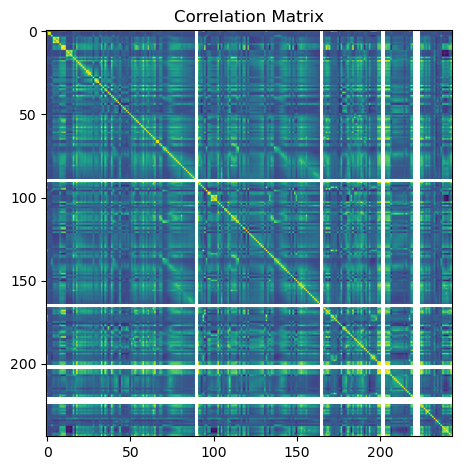

In [13]:
# include correlation values in each cell
show_correlation_values = False
# show names of columns next to image
show_column_names = False

# Get the correlation coefficients and put them into a 2-d array
n = len(cols_for_corr)
corrs_arr = df_corrs.to_numpy().reshape((n,n))

# Create a heatmap of the correlation matrix
fig, ax = plt.subplots()
im = ax.imshow(corrs_arr)

if show_column_names:
    # Put the columns names as labels
    ax.set_xticks(np.arange(len(cols_clean)), labels=cols_clean)
    ax.set_yticks(np.arange(len(cols_clean)), labels=cols_clean)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

if show_correlation_values:
    # Loop over data dimensions and create text annotations.
    for i in range(len(cols_clean)):
        for j in range(len(cols_clean)):
            text = ax.text(j, i, round(corrs_arr[i, j], 1),
                           ha="center", va="center", color="w")

ax.set_title("Correlation Matrix")
fig.tight_layout()
plt.show()

### Heatmap Legend

In [14]:
print("Legend\n")
for i, col in enumerate(cols_clean):
    print(f'{i}: {col}')

Legend

0: aggregate_travel_time_to_work
1: amerindian_including_hispanic
2: amerindian_pop
3: armed_forces
4: asian_including_hispanic
5: asian_male_45_54
6: asian_male_55_64
7: asian_pop
8: associates_degree
9: bachelors_degree
10: bachelors_degree_2
11: bachelors_degree_or_higher_25_64
12: black_including_hispanic
13: black_male_45_54
14: black_male_55_64
15: black_pop
16: children
17: children_in_single_female_hh
18: civilian_labor_force
19: commute_10_14_mins
20: commute_15_19_mins
21: commute_20_24_mins
22: commute_25_29_mins
23: commute_30_34_mins
24: commute_35_39_mins
25: commute_35_44_mins
26: commute_40_44_mins
27: commute_45_59_mins
28: commute_5_9_mins
29: commute_60_89_mins
30: commute_60_more_mins
31: commute_90_more_mins
32: commute_less_10_mins
33: commuters_16_over
34: commuters_by_bus
35: commuters_by_car_truck_van
36: commuters_by_carpool
37: commuters_by_public_transportation
38: commuters_by_subway_or_elevated
39: commuters_drove_alone
40: different_house_year_ago